In this notebook I am only interested in plotting basic data agregated by countries for the main occidental countries.

In [13]:
import sys
from IPython.display import display, Markdown

sys.path.append('../')

In [15]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

%matplotlib inline

In [17]:
from definitions import DATA_DIR, ROOT_DIR
from covid.data_download import download_data_from_kaggle, download_JHU, download_world_population
from covid.plotting import plot_by_country, plot_by_country_normalize
from covid.processing import get_start_date, filter_by_trigger_date, filter_data_by_countries, normalize_to_population

In [19]:
# dataset_kaggle_fname = download_data_from_kaggle()
# downloaded_files = list((ROOT_DIR / DATA_DIR).glob('*.csv'))

# print(f"Downloaded files:\n{chr(10).join(str(f.name) for f in downloaded_files)}")
# data_fname = ROOT_DIR / DATA_DIR / dataset_kaggle_fname

In [21]:
download_world_population()
data_fname = download_JHU()

In [23]:
data_raw = pd.read_csv(data_fname, parse_dates=['Date'])
data_raw.sample(10, random_state=0)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths
11238,NaN,Lithuania,55.1694,23.8813,2020-03-04,1,0
11774,NaN,Mexico,23.6345,-102.5528,2020-03-06,6,0
20169,NaN,Fiji,-17.7134,178.0650,2020-04-07,15,0
19467,NaN,Seychelles,-4.6796,55.4920,2020-04-04,10,0
18345,NaN,Hungary,47.1625,19.5033,2020-03-31,492,16
16905,New South Wales,Australia,-33.8688,151.2093,2020-03-26,1219,7
169,NaN,Netherlands,52.1326,5.2913,2020-01-22,0,0
17357,NaN,Slovakia,48.6690,19.6990,2020-03-27,269,0
19764,NaN,Vietnam,16.0000,108.0000,2020-04-05,241,0
14469,NaN,Turkey,38.9637,35.2433,2020-03-16,18,0


In [25]:
data_raw['Country/Region'].value_counts()

China                 3432
Canada                1456
France                1144
United Kingdom        1144
Australia              832
                      ... 
Dominican Republic     104
Liberia                104
Bhutan                 104
US                     104
Iraq                   104
Name: Country/Region, Length: 187, dtype: int64

I will drop the `Province/State`, `Lat`, `Long`.
For countries with a mainland and other territories (France and United Kingdom), I will keep the mainland. In the future, I may select some States form the USA.

In [27]:
rename_dict = {'Province/State': 'state', 'Country/Region': 'country', 'Confirmed': 'cases', 'Fatalities': 'deaths'}
data_raw = data_raw.rename(columns=rename_dict).rename(columns=lambda x: x.lower())

data_raw.columns

Index(['state', 'country', 'lat', 'long', 'date', 'cases', 'deaths'], dtype='object')

## Latest available date

In [29]:
display(Markdown(f"Latest available date in dataset: **{data_raw['date'].max().strftime('%d/%m/%Y')}**"))

Latest available date in dataset: **04/05/2020**

## Reduce country list here

In [31]:
# list of countries where only mainland is selected
countries_mainland = ['France', 'Italy', 'Germany', 'Sweden', 'United Kingdom', 'Spain', 'Belgium', 'Netherlands', 'Norway', 'Finland']
# list of countries that with multiple states will be aggregated by summing
countries_with_states = ['US']
# list of states to be considered as countries
single_states = [] # ['Washington', 'New York', 'California', 'Hubei']

data = filter_data_by_countries(data_raw, countries=countries_mainland, countries_with_states=countries_with_states, states=single_states)

In [33]:
data_raw

,state,country,lat,long,date,cases,deaths
0,NaN,Afghanistan,33.000000,65.000000,2020-01-22,0,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0
...,...,...,...,...,...,...,...
27451,NaN,Western Sahara,24.215500,-12.885800,2020-05-04,6,0
27452,NaN,Sao Tome and Principe,0.186360,6.613081,2020-05-04,23,3
27453,NaN,Yemen,15.552727,48.516388,2020-05-04,12,2
27454,NaN,Comoros,-11.645500,43.333300,2020-05-04,3,0


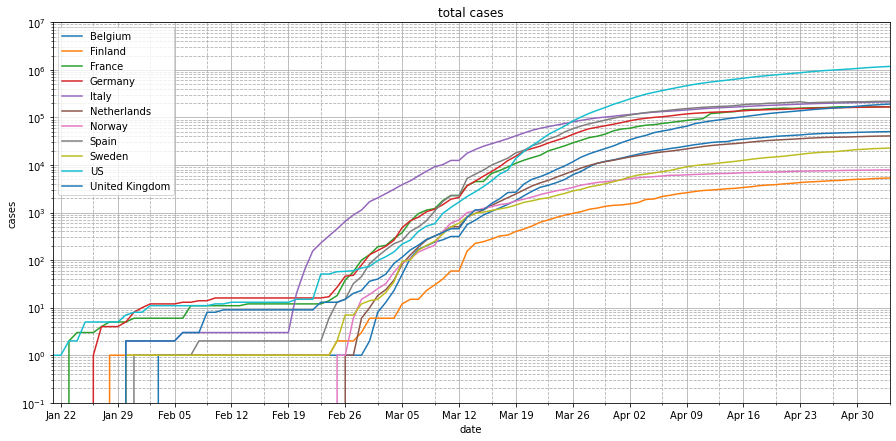

In [35]:
ax = plot_by_country(data, 'cases', 'total cases', logy=True)

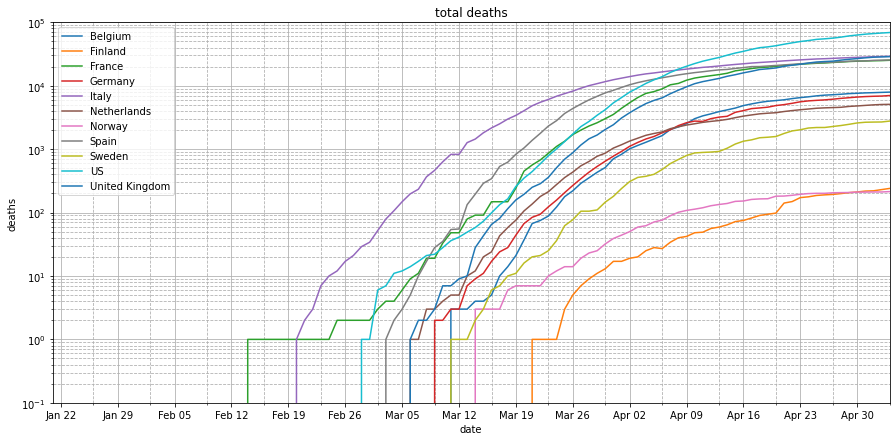

In [37]:
plot_by_country(data, 'deaths', 'total deaths', logy=True)

# Trigger date is when 100 cases are declared

In this section, for each country, day 0 is the day they had 100 cases.

Offsetting by this date, I plot the evolution of `cases` and `deaths`.

Keep in mind that some countries do more systematic checks (even of apparently healthy people) while others only check patients arriving at hospital with serious condition.

In [39]:
threshold = 1000
case_trigger = get_start_date(data, 'cases', threshold=threshold)
display(case_trigger)

country
Belgium          2020-03-16
Finland          2020-03-27
France           2020-03-08
Germany          2020-03-08
Italy            2020-02-29
Netherlands      2020-03-15
Norway           2020-03-14
Spain            2020-03-09
Sweden           2020-03-15
US               2020-03-11
United Kingdom   2020-03-14
Name: cases_trigger_date, dtype: datetime64[ns]

### Below is the offset for death trigger date compared to Italy (reference date)

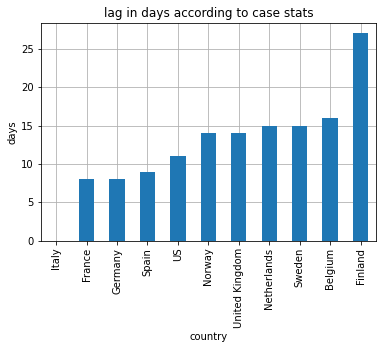

In [41]:
case_lags = case_trigger.apply(lambda x: x - case_trigger.min())
ax = case_lags.sort_values().astype('timedelta64[D]').rename('days').plot(kind='bar', grid=True, zorder=2, title='lag in days according to case stats')
ax.set(ylabel='days')
plt.show()

In [43]:
case_offset_data = filter_by_trigger_date(data, 'cases', threshold=threshold)
case_offset_data

,country,cases,deaths
date,,,
0 days,Belgium,50,0
1 days,Belgium,109,0
2 days,Belgium,169,0
3 days,Belgium,200,0
4 days,Belgium,239,0
...,...,...,...
58 days,United Kingdom,171253,26771
59 days,United Kingdom,177454,27510
60 days,United Kingdom,182260,28131


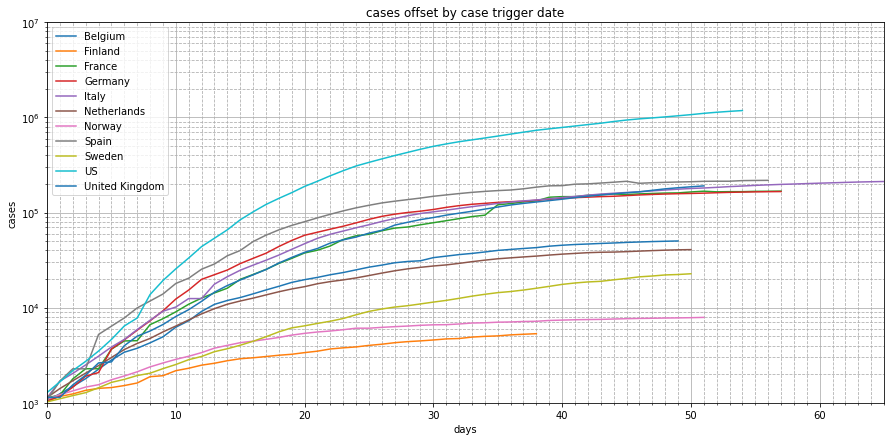

In [22]:
ax = plot_by_country(case_offset_data, 'cases', title='cases offset by case trigger date', logy=True)

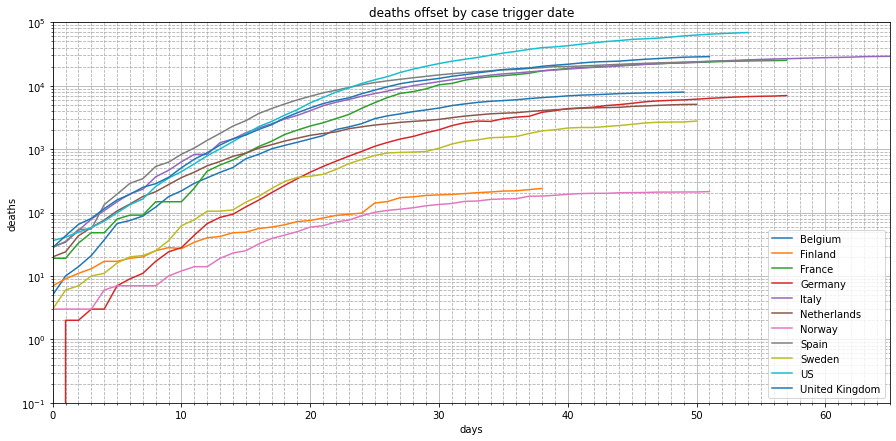

In [24]:
plot_by_country(case_offset_data, 'deaths', title='deaths offset by case trigger date', logy=True)

# Trigger date is when 20 deaths are declared
In this section, for each country, day 0 is the day they had 20 deaths.

Offsetting by this date, I plot the evolution of `cases` and `deaths`.

The reason I am looking at offsetting by death trigger date, is that the way different countries identify and count deaths is very similar, while for counting cases, some countries do systematic checks (leading to a low apparent mortality) and others check only serious cases ending in hospital (leading to a high apparent mortality)

In [26]:
threshold = 50
death_trigger = get_start_date(data, 'deaths', threshold=threshold)
display(death_trigger)

country
Belgium          2020-03-21
Finland          2020-04-12
France           2020-03-13
Germany          2020-03-20
Italy            2020-03-02
Netherlands      2020-03-18
Norway           2020-04-02
Spain            2020-03-11
Sweden           2020-03-25
US               2020-03-14
United Kingdom   2020-03-16
Name: deaths_trigger_date, dtype: datetime64[ns]

### Below is the offset for death trigger date compared to Italy (reference date)

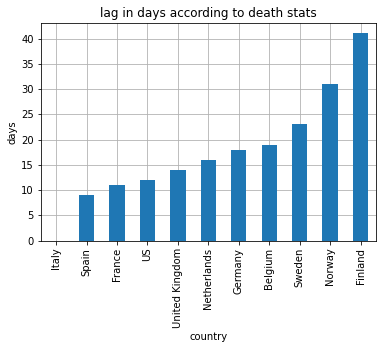

In [28]:
death_lags = death_trigger.apply(lambda x: x - death_trigger.min())
ax = death_lags.sort_values().astype('timedelta64[D]').rename('days').plot(kind='bar', grid=True, zorder=2, title='lag in days according to death stats')
ax.set(ylabel='days')
plt.show()

In [30]:
death_offset_data = filter_by_trigger_date(data, 'deaths', threshold=threshold)
death_offset_data

,country,cases,deaths
date,,,
0 days,Belgium,2815,67
1 days,Belgium,3401,75
2 days,Belgium,3743,88
3 days,Belgium,4269,122
4 days,Belgium,4937,178
...,...,...,...
45 days,United Kingdom,171253,26771
46 days,United Kingdom,177454,27510
47 days,United Kingdom,182260,28131


### lags between countries

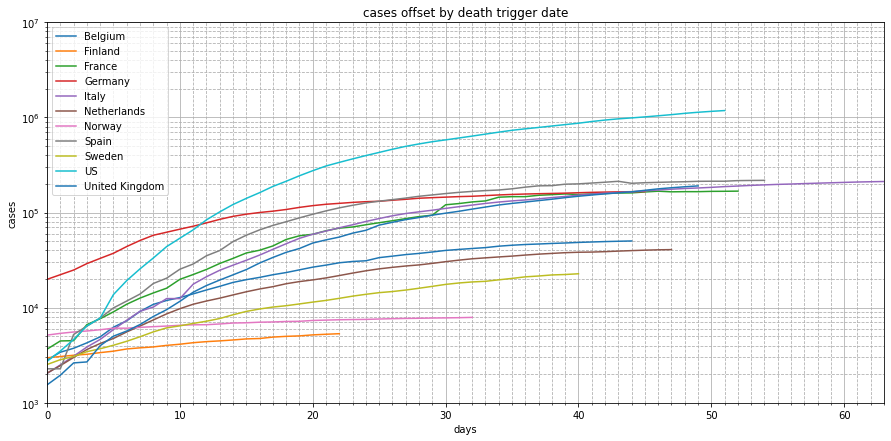

In [32]:
plot_by_country(death_offset_data, 'cases', title='cases offset by death trigger date', logy=True)

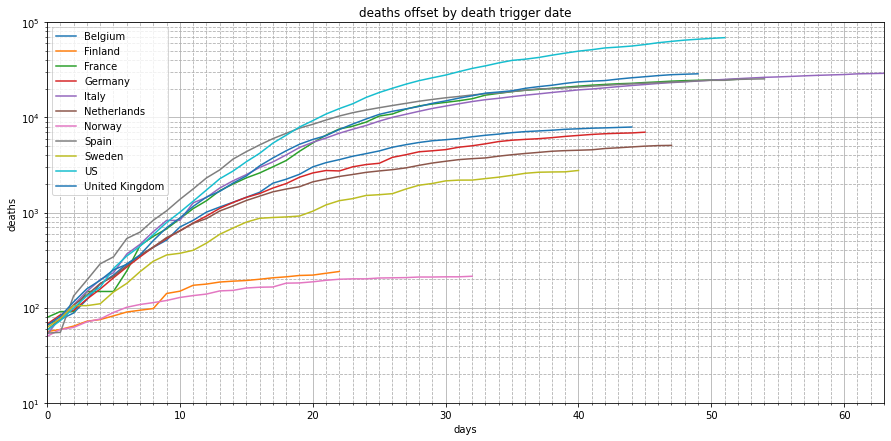

In [34]:
plot_by_country(death_offset_data, 'deaths', title='deaths offset by death trigger date', logy=True)

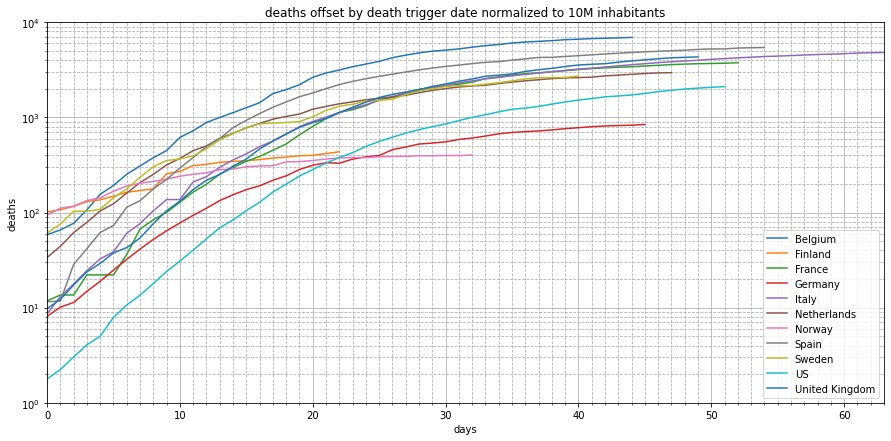

In [36]:
plot_by_country_normalize(death_offset_data, 'deaths', title='deaths offset by death trigger date normalized to 10M inhabitants', logy=True)

# Same as before but data is normalized to a population of 10M

In [38]:
normalized_data = normalize_to_population(data)

country
Belgium          2020-03-21
Finland          2020-04-05
France           2020-03-20
Germany          2020-03-28
Italy            2020-03-08
Netherlands      2020-03-20
Norway           2020-03-30
Spain            2020-03-15
Sweden           2020-03-25
US               2020-03-26
United Kingdom   2020-03-23
Name: deaths_trigger_date, dtype: datetime64[ns]

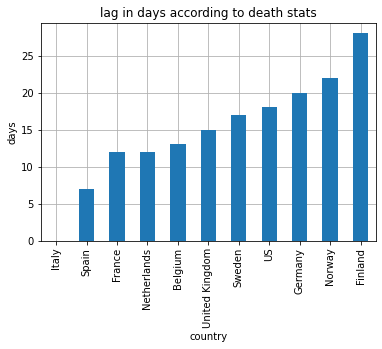

In [40]:
threshold = 50
death_trigger_norm = get_start_date(normalized_data, 'deaths', threshold=threshold)
display(death_trigger_norm)

death_lags_norm = death_trigger_norm.apply(lambda x: x - death_trigger_norm.min())
ax = death_lags_norm.sort_values().astype('timedelta64[D]').rename('days').plot(kind='bar', grid=True, zorder=2, title='lag in days according to death stats')
ax.set(ylabel='days')
plt.show()

In [42]:
death_offset_data_norm = filter_by_trigger_date(normalized_data, 'deaths', threshold=threshold)
death_offset_data_norm

,country,cases,deaths
date,,,
0 days,Belgium,2462.115779,58.600979
1 days,Belgium,2974.655689,65.598111
2 days,Belgium,3273.783076,76.968451
3 days,Belgium,3733.844497,106.706261
4 days,Belgium,4318.105009,155.686184
...,...,...,...
38 days,United Kingdom,25767.696899,4028.116376
39 days,United Kingdom,26700.734501,4139.310504
40 days,United Kingdom,27423.872498,4232.749683


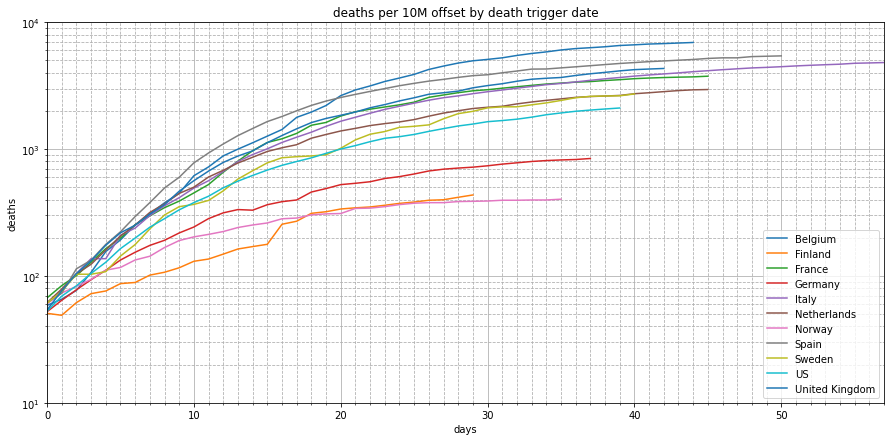

In [44]:
plot_by_country(death_offset_data_norm, 'deaths', title='deaths per 10M offset by death trigger date', logy=True)